In [ ]:
!pip install qiskit matplotlib pylatexenc networkx scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

En primer lugar vamos a importar las bibliotecas necesarias

In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer
from qiskit.visualization import plot_histogram
from networkx import Graph, draw
from scipy.optimize import minimize

Vamos a construir el circuito a partir del grafo y un vector que contiene los parámetros γ y β

In [ ]:
def obtener_circuito(G, theta):
  nqubits = len(G.nodes())
  circuito = QuantumCircuit(nqubits)
  p = len(theta)//2
  
  gamma = theta[:p]
  beta = theta[p:]

  # Preparamos una superposición de todos los estados con puertas de Hadamard
  for i in range(0, nqubits):
    circuito.h(i)
  
  # Repetimos p veces los circuitos con el Hamiltoniano del problema y de mezcla
  for i in range(0,p):
    # Circuito con el Hamiltoniano del problema
    for l,k in G.edges():
      circuito.rzz(2 * gamma[i],l,k)

    # Circuito con el Hamitoniano de mezcla
    for qbit in range(0,nqubits):
      circuito.rx(2 * beta[i], qbit)

  # Medida para obtener una solución
  circuito.measure_all()

  return circuito

Una vez que tenemos el circuito, vamos a preparar la función objetivo que va a usar el optimizador. Pero antes vamos a crear un entorno de ejecución (en este caso simulado) y preparamos una función para ejecutar el circuito asociado al grafo en dicho entorno. Esta función nos servirá también para obtener los reusltados una vez que el algoritmo clásico haya optimizado los parámetros del circuito.

In [ ]:
entorno = Aer.get_backend('qasm_simulator')

def ejecuta_circuito(G, theta, ejecuciones=1000):      
    circuito = obtener_circuito(G, theta)
    histograma = entorno.run(circuito, nshots=ejecuciones).result().get_counts()
    return histograma

La función objetivo debe ejecutar el circuito cuántico varias veces y calcular el promedio de la función objetivo para las soluciones extraídas en las distintas ejecuciones. Mostramos esta función a continuación, donde usamos como parámetro el vector de variables de decisión (los ángulos γ y β) y el número de ejecuciones del circuito cuántico.

In [ ]:
def funcion_objetivo(G, ejecuciones=1000):

  def cuenta_ejes_cruzados(solucion):
    ejes_cruzados = 0
    for i,j in G.edges():
      if solucion[i] != solucion[j]:
        ejes_cruzados += 1
    return ejes_cruzados
    
  def ejecuta_calcula_promedio(theta):
    histograma = ejecuta_circuito(G, theta, ejecuciones)

    suma = 0
    ejecs = 0
    for solucion, veces in histograma.items():
      # La solución viene invertida (el bit más significativo primero)
      ejes_cruzados = cuenta_ejes_cruzados(solucion[::-1])
      suma += ejes_cruzados * veces
      ejecs += veces

    return -suma/ejecs
    
  return ejecuta_calcula_promedio


Ahora solo nos queda utilizar un algoritmo de optimización clásico para resolver el problema. Aquí usaremos SLSQP de SciPy.

In [ ]:
def maximiza(G):
  objetivo = funcion_objetivo(G)
  return minimize(objetivo,[1.0,1.0,1.0,1.0], method='COBYLA')
  

Vamos a probar el algoritmo con un grafo de 5 vértices y 6 ejes.

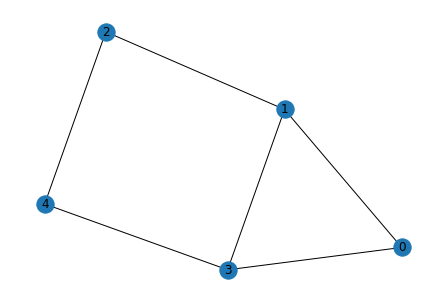

In [ ]:
G = Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(0,1),(0,3),(1,3),(1,2),(2,4),(3,4)])
draw(G, with_labels=True)

Ahora aplicamos QAOA para encontrar los parámetros de un circuito óptimo.

In [ ]:
resultado = maximiza(G)
resultado

     fun: -4.150390625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 43
  status: 1
 success: True
       x: array([0.30314406, 1.62691499, 1.17179955, 1.54316145])

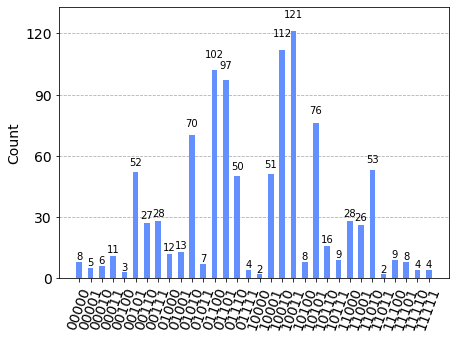

In [ ]:
histograma = ejecuta_circuito(G, [0.30314406, 1.62691499, 1.17179955, 1.54316145])
plot_histogram(histograma)